# Applying data analysis to medical data to improve society's quality of life

In [1]:
import numpy as np
import pylidc as pl
import matplotlib.pyplot as plt
from pylidc.utils import consensus
from skimage.measure import find_contours
import os
from scipy.ndimage import gaussian_filter

Did you know large hospitals can generate up to hundreds of terabytes of medical data each year? <br>
Aditionally, the amount of data hospitals generate only increase with time.

In many countries (almost all developed countries), hospitals are by law required to store this medical data for 5 to 10 years.

As (_nascent_) datascientists we recognize that this medical data can be provide priceless amount of information that could help improve health care. <br>
When properly refigned, this data could have a significant impact on society's quality of life.

It is therefore very dissapointing that as of today the large majority of medical data is simply stored and left unused, primarily due to privacy laws and regulations.

However, the consesus surrounding this topic is starting to shift and effort are being made to help the medical field reap the benefits of Data Science.

One of these effort is a website called "The Cancer Imaging Archieve (TCIA)" https://www.cancerimagingarchive.net/ <br>
Which contains a wealth of medical imaging data in a large variety of different forms (CT, MRI, microscopic biopsy, radiographs, ...)

In this notebook specifically, we will be looking at one of the most extensive datasets that can be found in this archive. <br>
The LIDC-IDRI dataset contains 1013 thoracic CT scans. These come in DICOM file format but can easily be transfered to numpy arrays.

All the CT scans in the dataset were taken with the intent of diagnosing / ruling out lung cancer.  <br>

Some facts about lung cancer that make this dataset all that more interesting:

- Cancer is the second most common cause of death only preceded by cardiovascular disease.
- Lung cancer is the second most prevelent form of cancer in both men and woman (secondary to prostate and breast cancer respectively).
- Lung cancer is one of the most lethal forms of cancer as it only has a 5 year survival rate of 20%

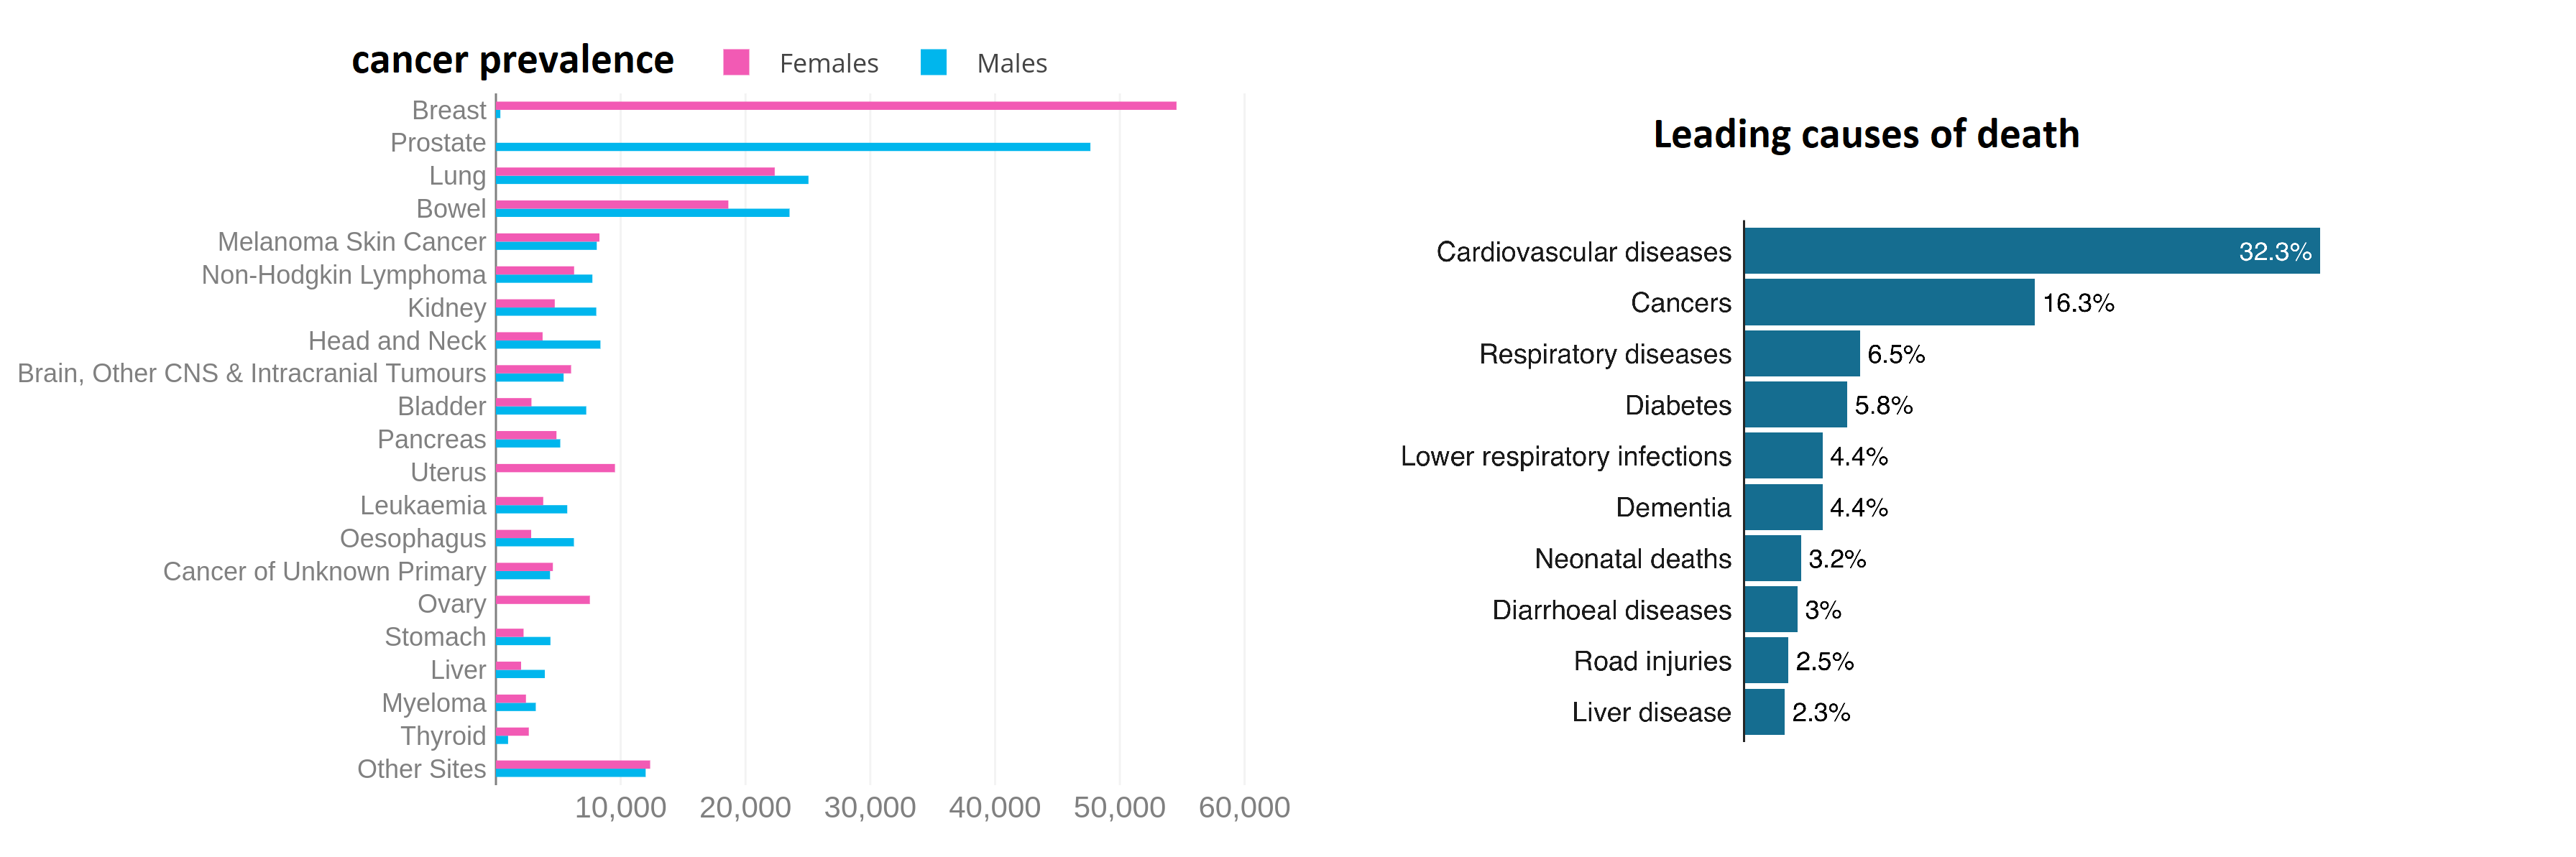

The combination of its high mortality and prevelence make lung cancer by far the most common cause of cancer related death.

This makes early diagnosis all that more important, the earlier a patient is diagnosed, the faster he/she can be treated, the higher the chance of recovery.

In addition to the 1013 CT scans, the dataset includes annotations from 4 different radiologists.
These annotations were obtained independently, afterwards the radiologists discussed their findings and finilized a total of 2669 detected long nodules (tumors).<br>
In realitiy there is even more nodules(7371), however, the radiologists only retained nodules that have an equivalent diameter greater than 3 mm. This is set as a thresh hold since smaller nodules are often not as harmful.<br>
The total count of nodules aswell as more information regarding the malignancy of the nodules is provided in xls files.

These annotations make this dataset especially interesting for applications in machine learning & computer aided diagnosis.

Loading dicom files ... This may take a moment.


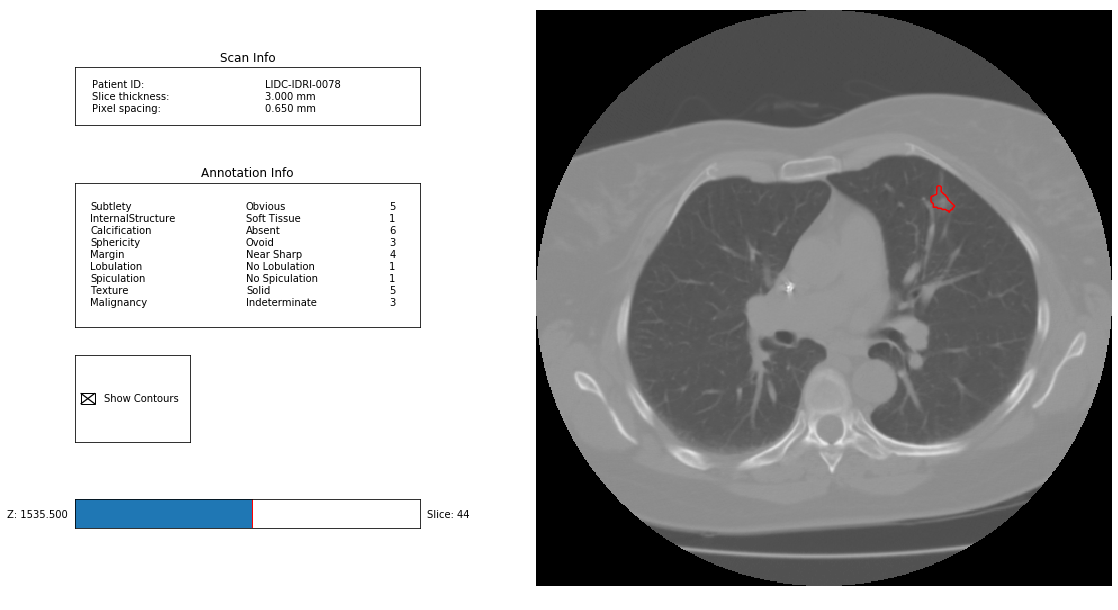

In [2]:
ann = pl.query(pl.Annotation)[0]
ann.visualize_in_scan()

However, they are also interesting for many other Data Science applications.

Some ideas:

- one could compare the shapes/sizee of the individual nodules and find a correlation with malignancy, in reality more spherical tumors tend be more likely to be benign.

 Spherephicity is a self-evident way of quantifying this.
 To every annotation a number can be assigned that represents how closely the shape represents a sphere (1: sphere, 0: lower dimensional shape)

Malignant tumor
Sphericity: 0.8273486867112941


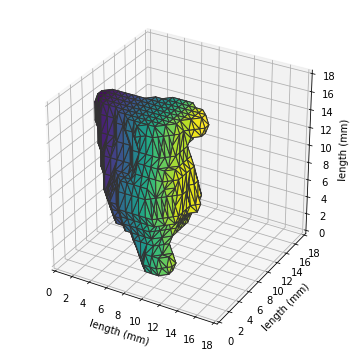

In [3]:
ann = pl.query(pl.Annotation)\
        .filter(pl.Annotation.malignancy == 5)[5]
print('Malignant tumor')
print('Sphericity: '+str(np.power(6*ann.volume, 2/3)*np.power(np.pi, 1/3)/ann.surface_area))
ann.visualize_in_3d()

Benign tumor
Sphericity: 0.8777946395184181


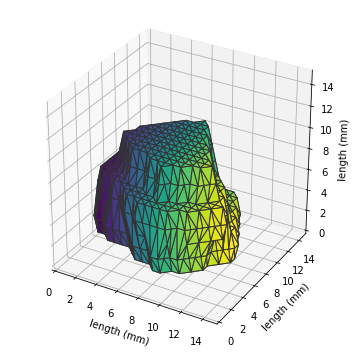

In [4]:
ann = pl.query(pl.Annotation)\
        .filter(pl.Annotation.malignancy == 1)[1]
print('Benign tumor')
print('Sphericity: '+str(np.power(6*ann.volume, 2/3)*np.power(np.pi, 1/3)/ann.surface_area))
ann.visualize_in_3d()

- One could look at the variance between the annotations of different radiologists and showcase the inconsistency of diagnosis between different radiologists. This problem may bemuch less prevalent in computer aided diagnosis.

Loading dicom files ... This may take a moment.


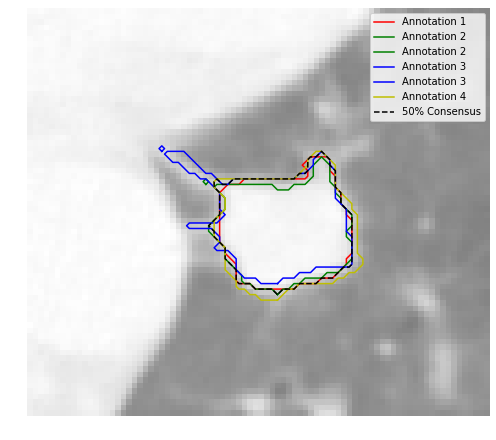

In [5]:
scan = pl.query(pl.Scan).filter(pl.Scan.patient_id == 'LIDC-IDRI-0078').first()
vol = scan.to_volume()

nods = scan.cluster_annotations()
anns = nods[0]

cmask,cbbox,masks = consensus(anns, clevel=0.5,
                              pad=[(20,20), (20,20), (0,0)])

k = int(0.5*(cbbox[2].stop - cbbox[2].start))

fig,ax = plt.subplots(1,1,figsize=(7,7))
ax.imshow(vol[cbbox][:,:,k], cmap=plt.cm.gray, alpha=0.5)

colors = ['r', 'g', 'b', 'y']
for j in range(len(masks)):
    for c in find_contours(masks[j][:,:,k].astype(float), 0.5):
        label = "Annotation %d" % (j+1)
        plt.plot(c[:,1], c[:,0], colors[j], label=label)

for c in find_contours(cmask[:,:,k].astype(float), 0.5):
    plt.plot(c[:,1], c[:,0], '--k', label='50% Consensus')

ax.axis('off')
ax.legend()
plt.tight_layout()
plt.show()

- One could use the large amount of annotations to contruct a probability map that can provide insight into which areas of the lung are most likely to develope tumors.

In [6]:
os.chdir('D:\Cropped')
nodules = np.zeros((512,512,200))
tumor_vol = np.zeros(1013)
i=1
while i < 1013:
    print(i)
    try:
        nod = np.load('_'+str(i)+'.npz')['arr_0']
        tumor_vol[i] = np.sum(nod)
        nodules += nod
        i+=1
    except:
        i+=1

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


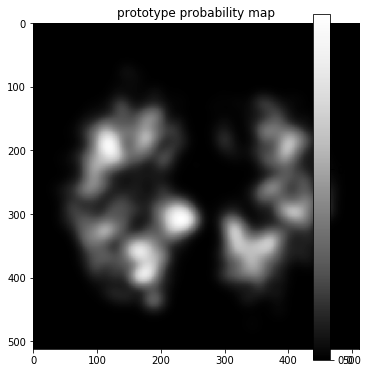

In [7]:
prob_map = gaussian_filter(nodules, sigma=10)

H = np.array(prob_map[:,:,95])
fig = plt.figure(figsize=(6, 6))
    
ax = fig.add_subplot(111)
ax.set_title('prototype probability map')
plt.imshow(H, cmap='Greys_r')
ax.set_aspect('equal')
    
cax = fig.add_axes([0.12, 0.1, 0.78, 0.8])
cax.get_xaxis().set_visible(False)
cax.get_yaxis().set_visible(False)
cax.patch.set_alpha(0)
cax.set_frame_on(False)
plt.colorbar(orientation='vertical')

plt.show()

This "probability distribution" suggests that tumors are more likely to form around the edges of the lung rather than around the primary bronchi, This may be explain by the fact that there is most tissue deeper in the lungs
Note: this plot is not at all correct as it does not take into account that the lungs have different volumes.
Ideally we want to rescale the nodule from the original lungs to a standerdized lung shape and project it on that standerdize lung

- Since the scale of each scan is know, using some segmentation algorithm we can estimate, forexample, the size of the patient. This can than be used together with the nodule counts to find correlations between the size of the patient and lung cancer.

The size/weight of the cells that make up the body of a big person are the same as those making up the body of a smaller person. This means that bigger people simply have more cells than smaller people. If the probability of a cell mutating to form cancer is approximately independent of how big a person is, there should be a linear relationship between the size of a person, and there probability to develope lung cancer.

For now I have used lung volume instead, altough it may seem like a logical assumption that there should be a linear relation between the size of a patient and their lung volume, we have to take into concideration that in the end we will be comparing lung volume to tumor volume, while the tumor volume may have a significant impact on lung volume. (when lungs are diseased, they tend to decrease in size). Thus, a future improvement would be segmenting the soft tissue instead (new problem: soft tissue is not completely captures in CT scan)

In [8]:
os.chdir('D:\Lungs')

In [9]:
lung = np.load('_'+str(2)+'.npz')['arr_0']
lung[lung>0.01]=1

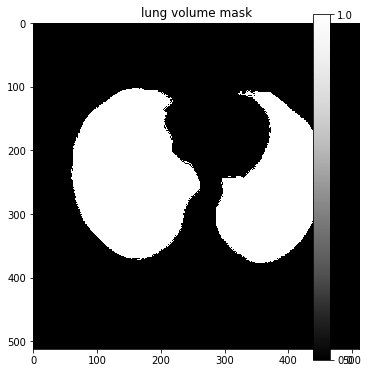

In [10]:
H = np.array(lung[:,:,60])
fig = plt.figure(figsize=(6, 6))
    
ax = fig.add_subplot(111)
ax.set_title('lung volume mask')
plt.imshow(H, cmap='Greys_r')
ax.set_aspect('equal')
    
cax = fig.add_axes([0.12, 0.1, 0.78, 0.8])
cax.get_xaxis().set_visible(False)
cax.get_yaxis().set_visible(False)
cax.patch.set_alpha(0)
cax.set_frame_on(False)
plt.colorbar(orientation='vertical')

plt.show()

In [20]:
lung_vol = np.zeros(1013)
i=0
while i < 1013:
    try:
        lung = np.load('_'+str(i)+'.npz')['arr_0']
        lung[lung>0.01]=1
        lung_vol[i] = np.sum(lung)
        print(i)
        i+=1
    except:
        i+=1

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
177
178
179
180
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
279
280


D:\programs\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  


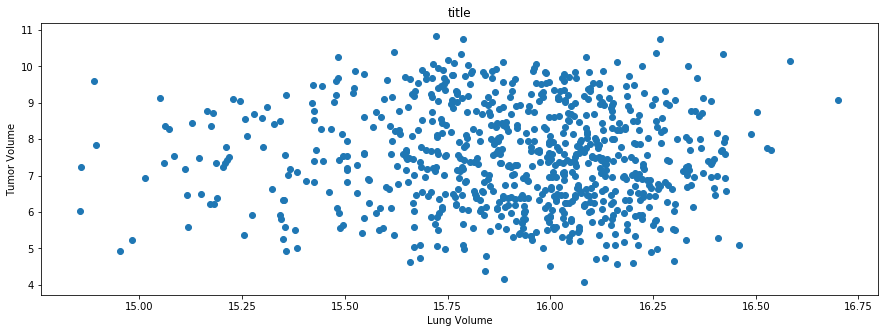

In [44]:
plt.figure(figsize=(15, 5))
plt.scatter(np.log(lung_vol), np.log(tumor_vol))
plt.title("title")
plt.xlabel("Lung Volume")
plt.ylabel("Tumor Volume")
plt.show()

In [48]:
print('Almost insignificant correlation: '+str(pearsonr(lung_vol, tumor_vol)[0]))

Almost insignificant correlation: -0.030038380637233148


**Notes:**
- All the above results are prototypes with much room for improvement
- Im not sure how specific our topic has to be, we can explore other forms of medical data rather than only this lung cancer example.